In [1]:
import torch
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.plot import pltCL, pltPhase

import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Quad Copter Model

A = torch.tensor([
    [1., 0., 0., 0., 0., 0., 0.1, 0., 0., 0., 0., 0.],
    [0., 1., 0., 0., 0., 0., 0., 0.1, 0., 0., 0., 0.],
    [0., 0., 1., 0., 0., 0., 0., 0., 0.1, 0., 0., 0.],
    [0.0488, 0., 0., 1., 0., 0., 0.0016, 0., 0., 0.0992, 0., 0.],
    [0., -0.0488, 0., 0., 1., 0., 0., -0.0016, 0., 0., 0.0992, 0.],
    [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.0992],
    [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
    [0.9734, 0., 0., 0., 0., 0., 0.0488, 0., 0., 0.9846, 0., 0.],
    [0., -0.9734, 0., 0., 0., 0., 0., -0.0488, 0., 0., 0.9846, 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.9846]
])
B = torch.tensor([
    [0., -0.0726, 0., 0.0726],
    [-0.0726, 0., 0.0726, 0.],
    [-0.0152, 0.0152, -0.0152, 0.0152],
    [-0., -0.0006, -0., 0.0006],
    [0.0006, 0., -0.0006, 0.0000],
    [0.0106, 0.0106, 0.0106, 0.0106],
    [0, -1.4512, 0., 1.4512],
    [-1.4512, 0., 1.4512, 0.],
    [-0.3049, 0.3049, -0.3049, 0.3049],
    [-0., -0.0236, 0., 0.0236],
    [0.0236, 0., -0.0236, 0.],
    [0.2107, 0.2107, 0.2107, 0.2107]])


# Constraints
u0 = 10.5916

#control constraints will be enforced by sigmoid activation
umin = torch.tensor([9.6, 9.6, 9.6, 9.6]) - u0
umax = torch.tensor([13., 13., 13., 13.]) - u0

#state constraints will be enforced through penalty methods
#constraints are only present on the first two state variables
xmin = torch.tensor([-np.pi / 6, -np.pi / 6]) 
xmax = torch.tensor([np.pi / 6, np.pi / 6])


# Objective function
Q = torch.diag(torch.tensor([0., 0., 10., 10., 10., 10., 0., 0., 0., 5., 5., 5.]))
R = 0.1 * torch.eye(4)


# reference states
xr = torch.tensor([0, 0., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0.]) #reference point to control to.

# Prediction horizon
N = 10



[nx, nu] = B.shape
n_horizon = N


# neural control policy
mlp = blocks.MLP(nx, nu*n_horizon, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[100, 100, 100, 100])
open_loop_policy = Node(mlp, ['X'], ['U_open_loop'], name='open_loop_policy')
policy_map = lambda OL_U : umin + torch.sigmoid(torch.reshape(OL_U,(OL_U.shape[0],n_horizon,nu)))*(umax - umin)
policy_buffer = Node(policy_map,['U_open_loop'],['U_open_loop_buffer'],name = 'policy_buffer')



# linear state space model
xnext = lambda x, u: x @ A.T + u @ B.T    
one_step_dynamics = Node(xnext, ['X', 'U_open_loop_buffer'], ['X'], name='integrator')
ol_system = System([one_step_dynamics])
ol_system.nsteps = n_horizon
#ol_system.show()


In [3]:
# Training dataset generation

x0min = np.array([-np.pi/6, -np.pi/6, -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])
x0max = np.array([np.pi/6, np.pi/6, 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

train_samples = 5000
dev_samples = 100
BATCH_SIZE = 100


train_data = DictDataset({'X':torch.unsqueeze(torch.tensor(np.random.uniform(low = x0min, high = x0max,size = (train_samples,len(x0min))),dtype = torch.float32),1)}, name='train')  # Split conditions into train and dev
dev_data = DictDataset({'X': torch.unsqueeze(torch.tensor(np.random.uniform(low = x0min, high = x0max,size = (dev_samples,len(x0min))),dtype = torch.float32),1)}, name='dev')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                           collate_fn=train_data.collate_fn, shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=BATCH_SIZE,
                                         collate_fn=dev_data.collate_fn, shuffle=False)

In [4]:
# td = next(iter(train_loader))
# dd = open_loop_policy(td)
# td = dict(td,**dd)
# dd = policy_buffer(td)
# td = dict(td,**dd)
# dd = ol_system(td)
# td = dict(td,**dd)

In [5]:
# Define optimization problem
u = variable('U_open_loop_buffer')
x = variable('X')

f =  torch.sum((x-xr)*(x - xr)*torch.diag(Q)) + torch.sum(u*u*torch.diag(R))
obj = f.minimize(weight=1.0, name='obj')
objectives = [obj]



state_upper_bound_penalty = 100.0*(x[:,:,0:2]<xmax)
state_lower_bound_penalty = 100.0*(x[:,:,0:2]>xmax)

constraints = [state_upper_bound_penalty, state_lower_bound_penalty]



loss = PenaltyLoss(objectives, constraints)
problem = Problem([open_loop_policy,policy_buffer,ol_system], loss)
optimizer = torch.optim.AdamW(open_loop_policy.parameters(), lr=0.001)

In [6]:
#problem.show()

In [7]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer=optimizer,
    epochs=1000,
    train_metric="train_loss",
    dev_metric="dev_loss",
    eval_metric='dev_loss',
    warmup=400,
)


best_model = trainer.train()

epoch: 0  train_loss: 211698.4375
epoch: 1  train_loss: 120780.890625
epoch: 2  train_loss: 113997.6015625
epoch: 3  train_loss: 111794.7578125
epoch: 4  train_loss: 110310.0
epoch: 5  train_loss: 108862.5703125
epoch: 6  train_loss: 107273.453125
epoch: 7  train_loss: 106480.203125
epoch: 8  train_loss: 106323.75
epoch: 9  train_loss: 105915.96875
epoch: 10  train_loss: 105458.3671875
epoch: 11  train_loss: 105570.7578125
epoch: 12  train_loss: 105383.4921875
epoch: 13  train_loss: 104925.34375
epoch: 14  train_loss: 104872.59375
epoch: 15  train_loss: 104701.296875
epoch: 16  train_loss: 104620.0703125
epoch: 17  train_loss: 104479.5390625
epoch: 18  train_loss: 104369.09375
epoch: 19  train_loss: 104146.53125
epoch: 20  train_loss: 104350.296875
epoch: 21  train_loss: 104237.671875
epoch: 22  train_loss: 104249.046875
epoch: 23  train_loss: 103984.578125
epoch: 24  train_loss: 103928.3984375
epoch: 25  train_loss: 103958.96875
epoch: 26  train_loss: 103696.140625
epoch: 27  train_lo

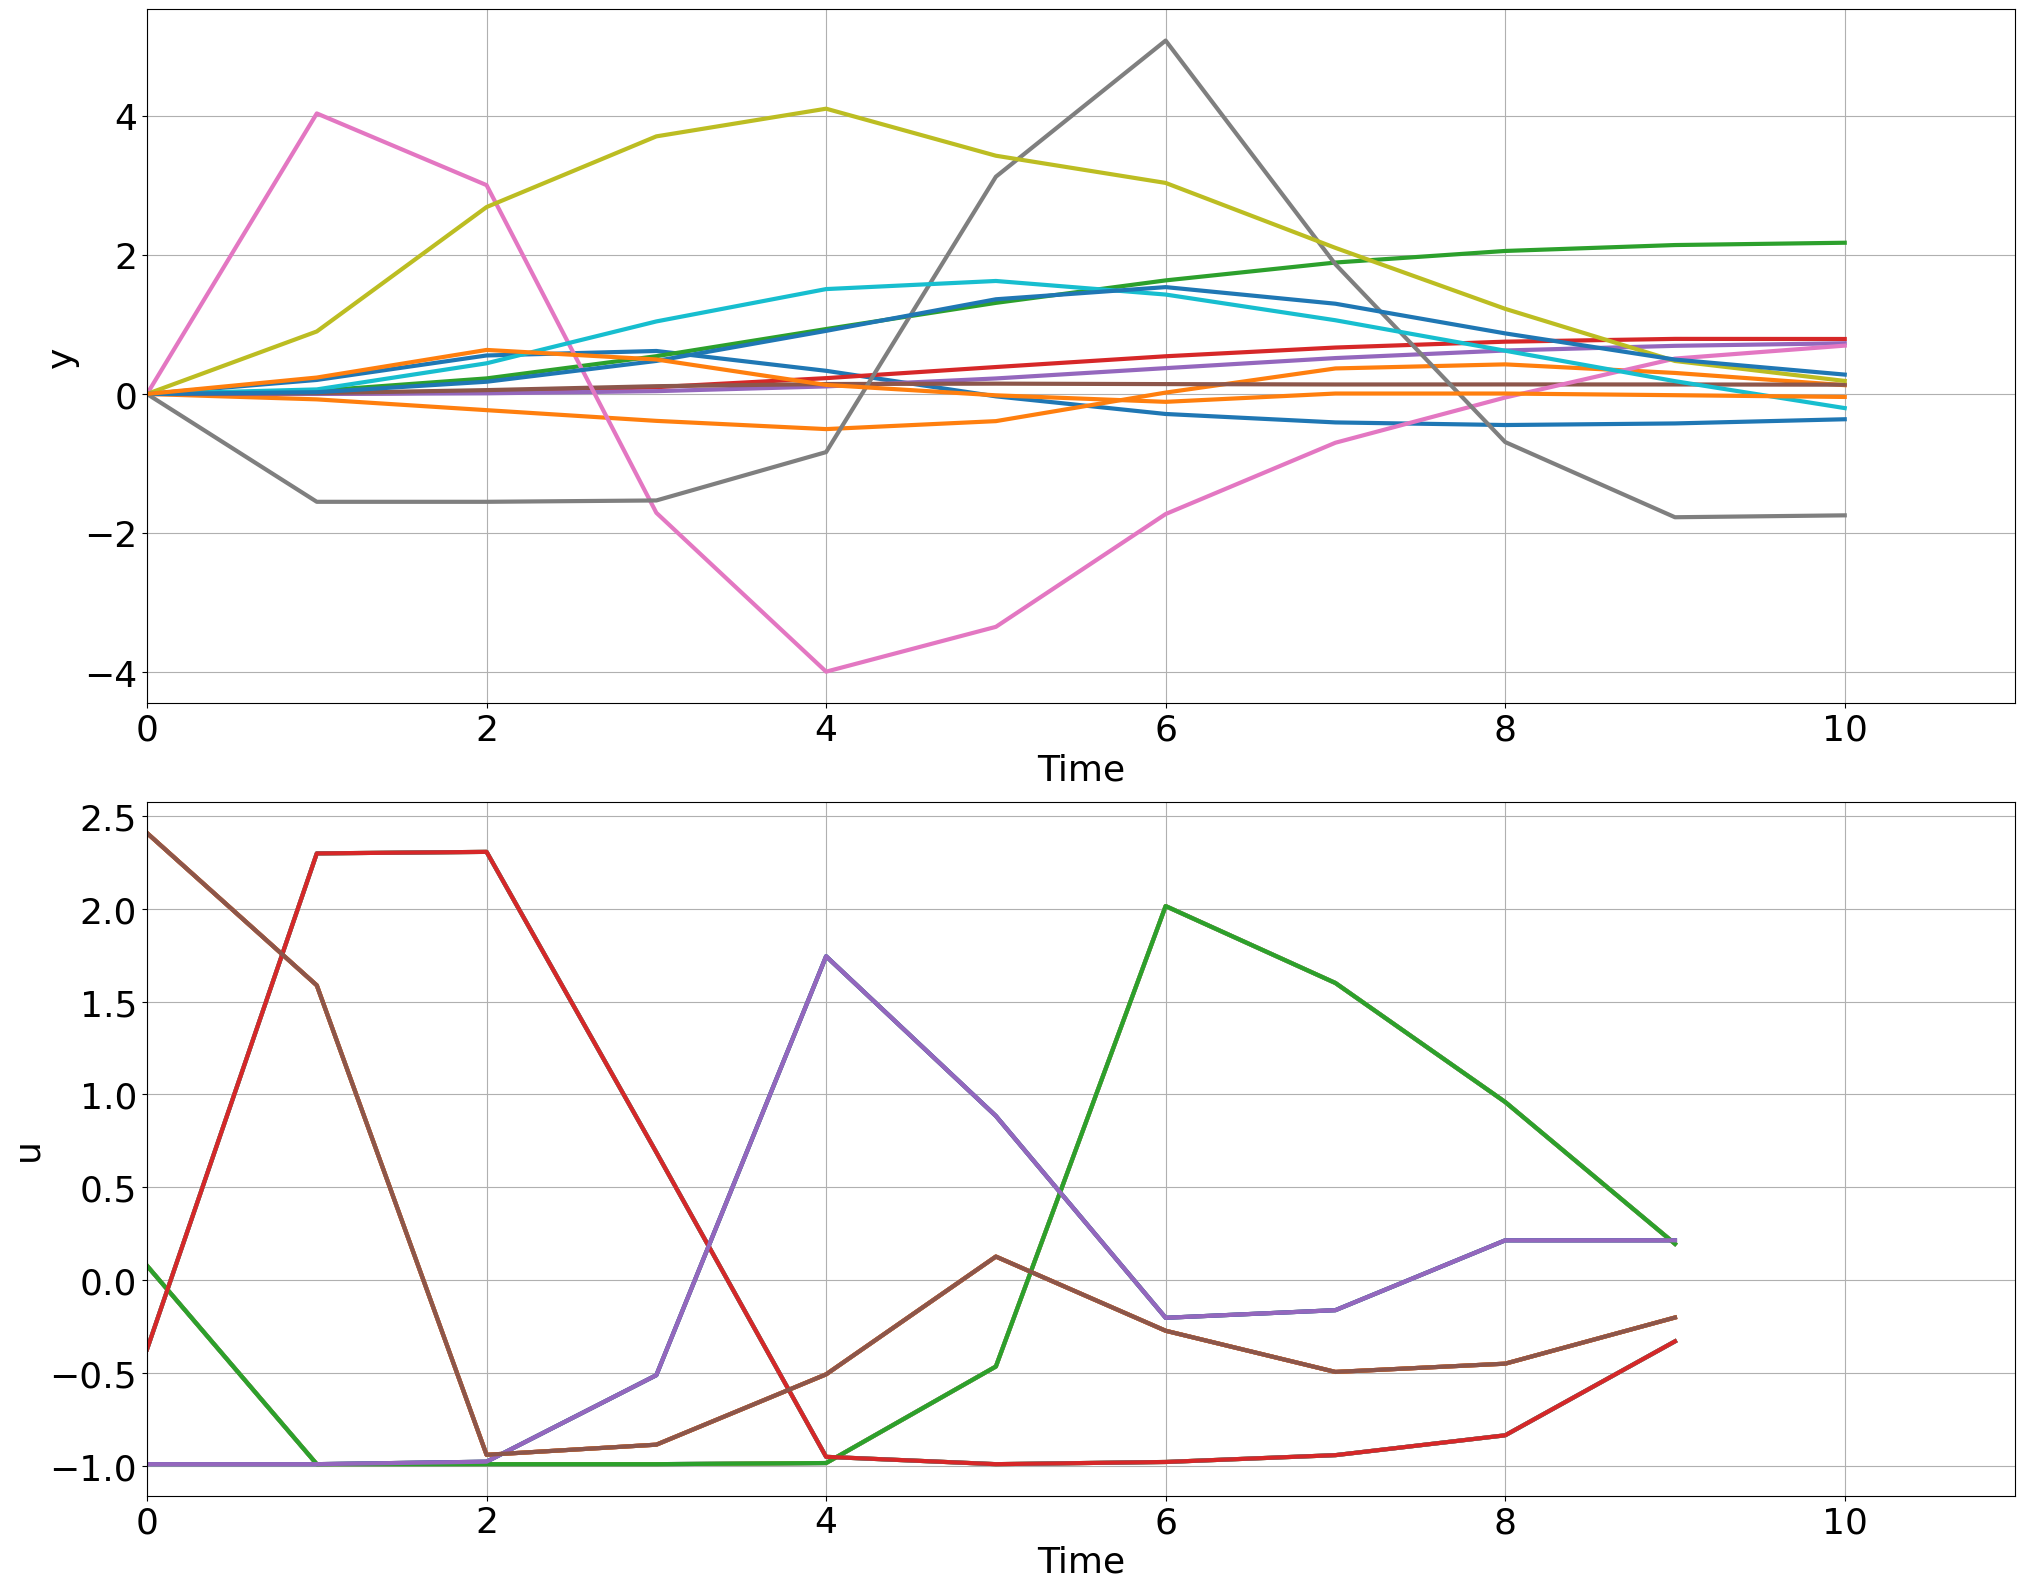

In [8]:
# Test best model 
problem.load_state_dict(best_model)
data = {'X': torch.zeros(1, 1, nx, dtype=torch.float32)}
nsteps = n_horizon
#nsteps = 30
#cl_system.nsteps = nsteps
dat = open_loop_policy(data)
data = dict(data,**dat)
dat = policy_buffer(data)
data = dict(data,**dat)
trajectories = ol_system(data)
pltCL(Y=trajectories['X'].detach().numpy().reshape(nsteps+1, nx), U=trajectories['U_open_loop_buffer'].detach().numpy().reshape(nsteps, nu), figname='cl.png')


In [9]:
''' 
Construct DR Correction
'''

''' 
Will assume that variable x is of form

[n_dim*(n_horizon + 1),u_dim*n_horizon,slacks]
'''

Q_x = Q
Q_u = R

'''
# DEFINE THE OBJECTIVE
'''
# x is assumed to include slack variables!
#def f_obj(x,p):
#    x_time = torch.reshape(x[:nx*(n_horizon+1)],(n_horizon+1,nx))
#    u_time = torch.reshape(x[nx*(n_horizon+1):nx*(n_horizon+1) + nu*n_horizon],(n_horizon,nu))
#    return torch.sum(x_time*torch.squeeze(torch.matmul(Q_x,torch.unsqueeze(x_time,-1)))) + torch.sum(u_time*torch.squeeze(torch.matmul(Q_u,torch.unsqueeze(u_time,-1))))


def f_obj(x,p):
    x_time = torch.reshape(x[nx:nx*(n_horizon+1)],(n_horizon,nx))
    u_time = torch.reshape(x[nx*(n_horizon+1):nx*(n_horizon+1) + nu*n_horizon],(n_horizon,nu))
    return torch.sum((x_time-xr)*torch.squeeze(torch.matmul(Q_x,torch.unsqueeze((x_time-xr),-1)))) + torch.sum(u_time*torch.squeeze(torch.matmul(Q_u,torch.unsqueeze(u_time,-1))))


'''
# DEFINE THE CONSTRAINTS
'''

def F_ineq(x,p):
    x_time = torch.reshape(x[:nx*(n_horizon+1)],(n_horizon+1,nx))
    x_angle_time = x_time[:,0:2]
    xat_lower_bound = torch.ravel(xmin - x_angle_time)
    xat_upper_bound = torch.ravel(x_angle_time - xmax)
    u_time = torch.reshape(x[nx*(n_horizon+1):nx*(n_horizon+1) + nu*n_horizon],(n_horizon,nu))
    u_lower_bound = torch.ravel(umin - u_time)
    u_upper_bound = torch.ravel(u_time - umax)
    return torch.cat((xat_lower_bound,xat_upper_bound,u_lower_bound,u_upper_bound))


def F_eq(x,p):
    x_time = torch.reshape(x[:nx*(n_horizon+1)],(n_horizon+1,nx))
    x_time_r = x_time[0:-1,:]
    x_time_f = x_time[1:,:]
    u_time = torch.reshape(x[nx*(n_horizon+1):nx*(n_horizon+1) + nu*n_horizon],(n_horizon,nu))
    initial_condition = x_time[0,:] - p
    dyn_time = torch.squeeze(torch.matmul(A,torch.unsqueeze(x_time_r,-1))) + torch.squeeze(torch.matmul(B,torch.unsqueeze(u_time,-1))) - x_time_f
    dyn = torch.ravel(dyn_time)
    return torch.cat((initial_condition,dyn))



In [10]:
import sys
sys.path.append('../New_Experiments')


import DRSolver as dr
from importlib import reload

reload(dr)



num_steps = 20 # number of DR iterations to take
initial_steps = 0
x_dim = nx*(n_horizon + 1) + nu*n_horizon # dimension of primal variable
n_ineq = 4*(n_horizon + 1) + 2*nu*n_horizon  #number of inequality constraints
n_eq = nx*(n_horizon + 1) #number of equality constraints
parm_dim = nx #number of problem parameters
order = 'second' # What order approximation of the objective to use {'first', 'second'}
project_fixedpt = False
#metric scaling parameters
initial_lb_P = 1e-1
initial_ub_P = 1e1
#initial_lb_P = 1/2
#initial_ub_P = 2
lb_P = 1.0/10.0
ub_P = 10.0
scl_lb_P = 0.05
scl_ub_P = 0.8
#lb_P = 1.0/100.0
#ub_P = 1.0
#scl_lb_P = 0.01
#scl_ub_P = 10.0
solver = dr.DRSolver(
    f_obj = f_obj,
    F_ineq = F_ineq,
    F_eq = F_eq,
    x_dim = x_dim, 
    n_ineq = n_ineq,
    n_eq = n_eq, 
    order = order,
    JF_fixed=True,
    parm_dim = parm_dim,
    num_steps = num_steps,
    initial_steps= initial_steps,
    initial_lb_P=initial_lb_P,
    initial_ub_P = initial_ub_P,
    lb_P = lb_P,
    ub_P = ub_P,
    scl_lb_P = scl_lb_P,
    scl_ub_P = scl_ub_P,
    project_fixedpt=project_fixedpt
    )





# REMAP THROUGH DR CORRECTION

def dr_map(x,u):
    x_init = x[:,0,:]
    x_cat = torch.reshape(x,(x.shape[0],nx*(n_horizon + 1)))
    u_cat = torch.reshape(u,(u.shape[0],nu*n_horizon))
    return torch.cat((x_cat,u_cat),dim = -1), x_init

dr_mapper = Node(dr_map,['X','U_open_loop_buffer'],['X0_primal','p'],name = 'dr_mapper')
DR_correction = Node(solver,['X0_primal','p'],['X_corrected','cnv_gap','X_hist'])



components = [open_loop_policy,policy_buffer,ol_system,dr_mapper, DR_correction]



## ADD A CONVERGENCE PENALTY
cnv_gap = variable("cnv_gap")
f_cnv = (cnv_gap)**2
cnv_obj = f_cnv.minimize(weight=1e8, name='cnv_obj')
objectives = [cnv_obj]
constraints = []



#create loss function
loss = PenaltyLoss(objectives, constraints)
#construct constrained optimization problem
problem = Problem(components, loss)



In [11]:

'''
#######################################
#######################################

Train DR correction layer

#######################################
########################################
'''

DR_train_epochs = 40
optimizer = torch.optim.AdamW(solver.parameters(), lr=1e-3)
# define trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer,
    epochs=DR_train_epochs,
    patience=500,
    warmup=100,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
)

# Train solution map
best_model = trainer.train()


epoch: 0  train_loss: 62417.90625
epoch: 1  train_loss: 24769.412109375
epoch: 2  train_loss: 23488.38671875
epoch: 3  train_loss: 22797.087890625
epoch: 4  train_loss: 22272.1796875
epoch: 5  train_loss: 21822.267578125
epoch: 6  train_loss: 21430.294921875
epoch: 7  train_loss: 20938.537109375
epoch: 8  train_loss: 20498.078125
Interrupted training loop.


In [12]:
solver.num_steps = 200

In [13]:

td = {'X': torch.zeros(1, 1, nx, dtype=torch.float32)}
#td = next(iter(train_loader))
dd = open_loop_policy(td)
td = dict(td,**dd)
dd = policy_buffer(td)
td = dict(td,**dd)
dd = ol_system(td)
td = dict(td,**dd)
dd = dr_mapper(td)
td = dict(td,**dd)

dd = DR_correction(td)
td = dict(td,**dd)

In [14]:
x_corrected = td['X_corrected']
x_time = torch.reshape(x_corrected[:,:nx*(n_horizon+1)],(x_corrected.shape[0],n_horizon+1,nx))
u_time = torch.reshape(x_corrected[:,nx*(n_horizon+1):nx*(n_horizon+1) + nu*n_horizon],(x_corrected.shape[0],n_horizon,nu))


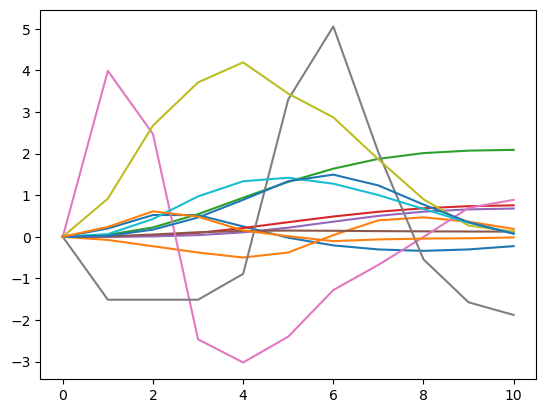

In [15]:
import matplotlib.pyplot as plt
plt.plot(x_time[0,:,:].detach().numpy())

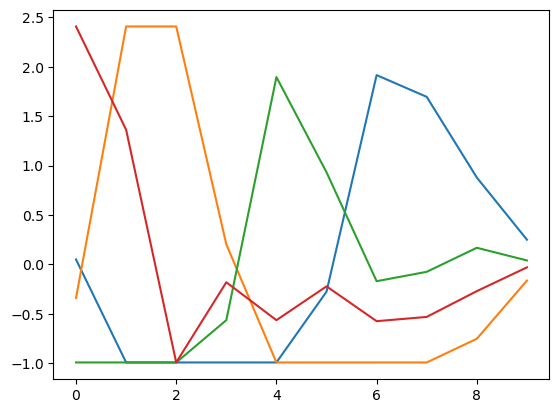

In [16]:
plt.plot(u_time[0,:,:].detach().numpy())

In [17]:
''' 
Check CVXPY
'''


import cvxpy as cv
import numpy as np
import scipy as sp
from scipy import sparse
from pylab import *
import time

# Discrete time model of a quadcopter
Ad = sparse.csc_matrix([
    [1., 0., 0., 0., 0., 0., 0.1, 0., 0., 0., 0., 0.],
    [0., 1., 0., 0., 0., 0., 0., 0.1, 0., 0., 0., 0.],
    [0., 0., 1., 0., 0., 0., 0., 0., 0.1, 0., 0., 0.],
    [0.0488, 0., 0., 1., 0., 0., 0.0016, 0., 0., 0.0992, 0., 0.],
    [0., -0.0488, 0., 0., 1., 0., 0., -0.0016, 0., 0., 0.0992, 0.],
    [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.0992],
    [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
    [0.9734, 0., 0., 0., 0., 0., 0.0488, 0., 0., 0.9846, 0., 0.],
    [0., -0.9734, 0., 0., 0., 0., 0., -0.0488, 0., 0., 0.9846, 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.9846]
])
Bd = sparse.csc_matrix([
    [0., -0.0726, 0., 0.0726],
    [-0.0726, 0., 0.0726, 0.],
    [-0.0152, 0.0152, -0.0152, 0.0152],
    [-0., -0.0006, -0., 0.0006],
    [0.0006, 0., -0.0006, 0.0000],
    [0.0106, 0.0106, 0.0106, 0.0106],
    [0, -1.4512, 0., 1.4512],
    [-1.4512, 0., 1.4512, 0.],
    [-0.3049, 0.3049, -0.3049, 0.3049],
    [-0., -0.0236, 0., 0.0236],
    [0.0236, 0., -0.0236, 0.],
    [0.2107, 0.2107, 0.2107, 0.2107]])
[nx, nu] = Bd.shape

# Constraints
u0 = 10.5916
uminc = np.array([9.6, 9.6, 9.6, 9.6]) - u0
umaxc = np.array([13., 13., 13., 13.]) - u0
xminc = np.array([-np.pi / 6, -np.pi / 6, -np.inf, -np.inf, -np.inf, -1.,
                 -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf])
xmaxc = np.array([np.pi / 6, np.pi / 6, np.inf, np.inf, np.inf, np.inf,
                 np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])

# Objective function
Qs = sparse.diags([0., 0., 10., 10., 10., 10., 0., 0., 0., 5., 5., 5.])
QNs = Qs
Rs = 0.1 * sparse.eye(4)

# Initial and reference states
xrc = np.array([0, 0., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0.])

# Prediction horizon
N = n_horizon

# Define problem
uc = cv.Variable((nu, N))
xc = cv.Variable((nx, N + 1))
x_init = cv.Parameter(nx)
objectivec = 0
constraintsc = [xc[:, 0] == x_init]
for k in range(N):
    objectivec += cv.quad_form(xc[:, k] - xrc, Qs) + cv.quad_form(uc[:, k], Rs)
    constraintsc += [xc[:, k + 1] == Ad @ xc[:, k] + Bd @ uc[:, k]]
    constraintsc += [ xc[:, k]>=xminc, xc[:, k] <= xmaxc]
    constraintsc += [uminc <= uc[:, k], uc[:, k] <= umaxc]
constraintsc +=[ xc[:, k+1]>=xminc, xc[:, k+1] <= xmaxc]
objectivec += cv.quad_form(xc[:, N] - xrc, QNs)
prob = cv.Problem(cv.Minimize(objectivec), constraintsc)



'''
Solve single instance
'''

# x0min = np.array([-np.pi/6, -np.pi/6, -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])
# x0max = np.array([np.pi/6, np.pi/6, 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
# x0 = np.random.uniform(low = x0min, high = x0max)
# #x0 = np.array([0.5, -0.5, -1., -1., 0., 0., 0., 0., 0., 0., 0., 0.])

x0 = np.zeros(nx)

x_init.value = x0
prob.solve(solver=cv.OSQP, warm_start=True,verbose = True)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Feb 26 08:54:58 AM: Your problem has 172 variables, 53 constraints, and 12 parameters.
(CVXPY) Feb 26 08:54:58 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 26 08:54:58 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 26 08:54:58 AM: Compiling problem (target solver=OSQP).
(CVXPY) Feb 26 08:54:58 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Feb 26 08:54:58 AM: Applying reduction CvxAttr2Constr
(CVXPY) Feb 26 08:54:58 AM: Applying reduction Qp2Symbolic

870.4358411249583

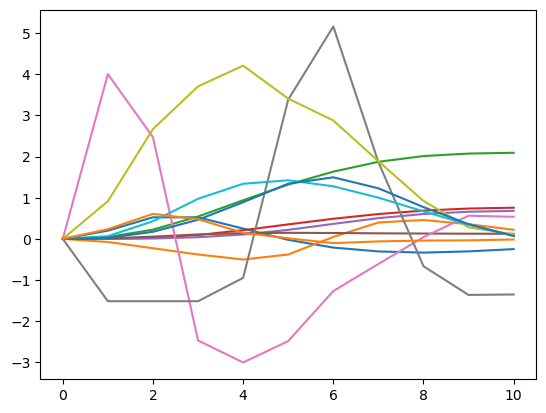

In [18]:
plt.plot(np.transpose(xc.value))

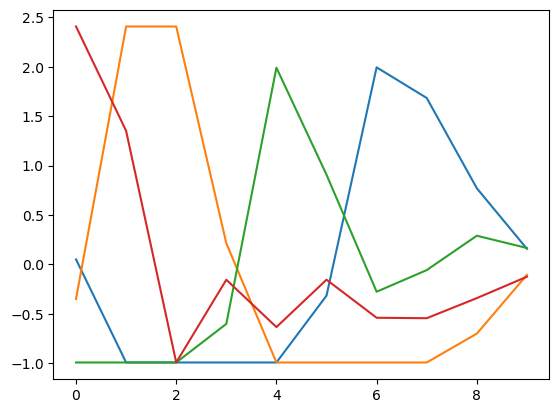

In [19]:
plt.plot(np.transpose(uc.value))

In [20]:
''' 
Compute difference
'''

xdr = x_time.detach().numpy()
udr = u_time.detach().numpy()

print('relative difference in state traj: ',np.sum((xdr - np.transpose(xc.value))**2)/(np.sum(xc.value**2)))

print('relative difference in controls: ', np.sum((udr - np.transpose(uc.value))**2)/(np.sum(uc.value**2)) )

relative difference in state traj:  0.002644122911106184
relative difference in controls:  0.0024734584050756436
